In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score
from scipy.stats import wilcoxon, mannwhitneyu, linregress


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection

import torch

import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        from tools import lstm
        reload(lstm)
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs
        reload(dt)

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    # %run "fig2.ipynb"

    print('Done')

Done


In [38]:
from scipy.linalg import inv
try:
    matlab.engine
    print('Matlab engine already running!')
except NameError:
    import matlab.engine
    eng = matlab.engine.start_matlab()
    eng.cd(r'../tools/dPCA/', nargout=0)
        
def vaf_pyal(df1:pd.DataFrame, field1: str, epoch1,
               df2:pd.DataFrame, field2: str, epoch2,
               n_components:int =10) -> (np.ndarray, np.ndarray):
    """
    Measure vaf for each CCA axis, between 2 DataFrames, fields, time epochs.
    epoch1, epoch2: an instance of the `pyal.generate_epoch_fun` function.
    """
 
    df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
    rates_1 = np.concatenate(df1[field1].values, axis=0)
    rates_1_model = PCA(n_components=n_components, svd_solver='full').fit(rates_1)
    rates_1_C = rates_1_model.components_
    df1 = pyal.apply_dim_reduce_model(df1, rates_1_model, field1, '_pca');
    pca_1_data = np.concatenate(df1['_pca'].values, axis=0)

    
    df2 = pyal.restrict_to_interval(df2, epoch_fun=epoch2)
    rates_2 = np.concatenate(df2[field2].values, axis=0)
    rates_2_model = PCA(n_components=n_components, svd_solver='full').fit(rates_2)
    rates_2_C = rates_2_model.components_
    df2 = pyal.apply_dim_reduce_model(df2, rates_2_model, field2, '_pca');
    pca_2_data = np.concatenate(df2['_pca'].values, axis=0)
    
    
    # same number of timepoints in both matrices
    n_samples = min ([pca_1_data.shape[0], pca_2_data.shape[0]])
    pca_1_data = pca_1_data[:n_samples,:]
    pca_2_data = pca_2_data[:n_samples,:]

    A, B, *_ = dt.canoncorr(pca_1_data, pca_2_data, fullReturn=True)
    vafs1 = vaf_cc(rates_1, rates_1_C, A)
    vafs2 = vaf_cc(rates_2, rates_2_C, B)
    
    return vafs1, vafs2

def vaf_cc(X, C, A):
    W = C.T@A #neural -> CCs
    V = W@inv(A.T@A) #neural -> CCs 
    vaf = eng.dpca_explainedVariance(X.T, W, V)['cumulativeDPCA']
    return vaf

Matlab engine already running!


In [32]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [55]:
@utility.report
def plot_monkey_vaf_cca(ax, full_list_MCx, allDFs_MCx):
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    
    field = monkey_defs.areas[2]+'_rates'
    vafs1 = []
    vafs2 = []
    vafs = []
    for df1,df2 in zip(side1df,side2df):
        vafs1_, vafs2_ = vaf_pyal(
            df1, field, monkey_defs.exec_epoch, 
            df2, field, monkey_defs.exec_epoch)
        vafs1.append(np.array(vafs1_)[0])
        vafs2.append(np.array(vafs2_)[0])
        vafs.append(np.mean([vafs1_, vafs2_], axis = 0).flatten())

    vafs1 = np.array(vafs1)
    vafs2 = np.array(vafs2)
    vafs = np.array(vafs).T
    print(vafs.shape)
    x_ = np.arange(1,monkey_defs.n_components+1)
    for vaf in vafs.T:
        # ax.plot(x_, vafs1[i], color='grey', alpha = 0.3)
        # ax.plot(x_, vafs2[i], color='grey', alpha = 0.3)
        ax.plot(x_, vaf, color = 'grey', alpha = 0.3)
    utility.shaded_errorbar(ax, x_, vafs, color='k', marker = 'o')

    ax.set_xlabel("Neural mode")
    ax.set_ylabel('VAF (\%)')

    return vafs
        

/tmp/ipykernel_1689/2145824657.py:18: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
/tmp/ipykernel_1689/2145824657.py:18: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
/tmp/ipykernel_1689/2145824657.py:18: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
/tmp/ipykernel_1689/2145824657.py:18: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  df1 = pyal.restrict_to_interval(df1,epoch_fun=epoch1)
/tmp/ipykernel_1

(10, 126)
Executed: `plot_monkey_vaf_cca` in 43.6s


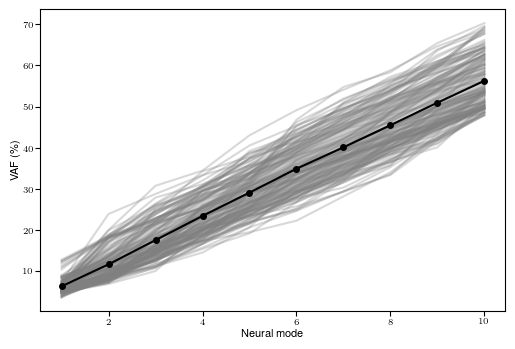

In [56]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig,ax = plt.subplots(dpi=100)
    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    vafs = plot_monkey_vaf_cca(ax,full_list_MCx, allDFs_MCx)

    plt.savefig(root / f'../figures/vaf_cca_monkeys.pdf', format= 'pdf')
    
    # plt.show()